In [1]:
%%capture
!pip install openpyxl
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import os

In [2]:
bandwidth = 2
for_r = 35

In [3]:
actual_path = os.getcwd()
os.chdir('/home/onyxia/work/material_science/Spetral_clustering')
%run rbf.ipynb
os.chdir(actual_path)

In [4]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
max_calculated = max_calculated.set_index('prettyformula',drop=True)
whole_data = max_elemental.copy()
x_group = pd.get_dummies(whole_data['X_X_group'],prefix='x_g',dtype=float)
a_group = pd.get_dummies(whole_data['A_A_group'],prefix='a_g',dtype=float)
m_group = pd.get_dummies(whole_data['M_M_group'],prefix='m_g',dtype=float)
whole_data = whole_data.drop(['X_X_group','A_A_group','M_M_group'],axis=1)
whole_data = pd.concat([whole_data,x_group,a_group,m_group],axis=1)

test_tree = DecisionTreeClassifier().fit(X=whole_data.drop(['class'],axis=1),
                                                              y=whole_data['class'])

imp_feat = test_tree.feature_importances_
names_feat = test_tree.feature_names_in_

imp_feat = imp_feat.reshape(-1,1)
names_feat = names_feat.reshape(-1,1)
test_df = pd.DataFrame(np.hstack((names_feat,imp_feat)))
test_df.columns = ['names_feat','imp_feat']
test_df = test_df.set_index('names_feat',drop=True)
test_df = test_df[test_df['imp_feat'] > 0]

diff_z = list(test_df.index)


number_of_atoms = np.zeros(n_samples)
compteur = 0
for element in whole_data.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1

columns_name = whole_data.drop(['class'],axis=1).columns.copy()
normalized = whole_data.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(-1,1)

data_norm = pd.DataFrame(normalized)
data_norm.columns = columns_name
data_norm['compound_name'] = whole_data.index
data_norm = data_norm.set_index('compound_name',drop=True)

data_norm = data_norm.filter(items=list(diff_z),axis=1)
data_norm['class'] = whole_data['class'].copy()

retained_features = list(test_df.index)

for feat in diff_z:
    if len(feat) > 5:
        retained_features.remove(feat)

list_dummies = []

for i in retained_features:
    if 'M_' in i:
        list_dummies.append(i)
    elif 'A_' in i:
        list_dummies.append(i)
    elif 'X_' in i:
        list_dummies.append(i)

for col in list_dummies:
    for row in data_norm.index:
        if data_norm.loc[row,col] != 0:
            data_norm.loc[row,col] = 1

In [5]:
data_norm['label'] = np.zeros(n_samples)
for i in data_norm.index:
    if data_norm.loc[i,'class'] == 1:
        data_norm.loc[i,'label'] = 1
    else:
        data_norm.loc[i,'label'] = -1
positive_samples = data_norm[data_norm['label'] == 1]
unlabelled_samples = data_norm[data_norm['label'] == -1]

In [6]:
list_of_imp_elem = list(positive_samples.index)
predictions_pos = np.zeros(15)
proba_pos = np.zeros(15)
count_elem = 0
for elem_part in list_of_imp_elem:
    max_elem_norm = data_norm.drop(elem_part,axis=0)
    n_samples = max_elem_norm.shape[0]
    #modification to fit with the previous versions
    n_cluster = 8
    clustering = KMeans(n_clusters=n_cluster).fit(X=max_elem_norm.to_numpy()[:,:-2])
    max_elem_norm['cluster'] = clustering.labels_
    list_of_ratio = np.zeros(n_cluster)
    for i in range(n_cluster):
        list_of_ratio[i] = max_elem_norm[max_elem_norm['cluster'] == i]['class'].sum()/max_elem_norm[max_elem_norm['cluster'] == i].shape[0]
    #same code as before but here we use the class because it is 0 or 1
    positive_cluster = np.argmax(list_of_ratio)
        
    #we cannot exactly compute the ratios because the classes are so unbalanced that in any cases the number of positive
    #instances will be very small compared to the ones of unlabelled instances
    
    list_of_dist = np.zeros(n_cluster)
    for i in range(n_cluster):
        list_of_dist[i] = np.linalg.norm(clustering.cluster_centers_[positive_cluster,:] - clustering.cluster_centers_[i,:])
    
    negative_cluster = np.argmax(list_of_dist)
    df_unlab_pop = max_elem_norm[max_elem_norm['label'] == -1]
    list_of_pop = pd.DataFrame(df_unlab_pop.groupby('cluster')['label'].count())
    list_of_pop.columns = ['pop']
    list_of_pop['dist'] = list_of_dist #distance to the positive cluster
    list_of_pop = list_of_pop.sort_values('dist',ascending=False)
    list_of_pop['cumsum'] = np.cumsum(list_of_pop['pop'])
    reliable_positives = max_elem_norm[max_elem_norm['label'] == 1]
    n_positives = reliable_positives.shape[0]
    last_step = np.where(np.array(list_of_pop['cumsum'])>n_positives*for_r)[0][0]
    index_ordered_distance = list(list_of_pop.index)
    if last_step == 0:
        reliable_negatives = max_elem_norm[max_elem_norm['cluster'] == negative_cluster]
        reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
    else:
        compteur=0
        reliable_negatives = max_elem_norm[max_elem_norm['cluster'] == negative_cluster]
        reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]
        while compteur<last_step:
            interm_negatives = max_elem_norm[max_elem_norm['cluster'] == index_ordered_distance[compteur+1]]
            interm_negatives = interm_negatives[interm_negatives['label'] == -1]
            reliable_negatives = pd.concat([reliable_negatives,interm_negatives])
            compteur += 1
        del interm_negatives, compteur
    
    reliable_negatives = reliable_negatives.head(n=n_positives*for_r)
    
    #Step of initialization of labels
    train_clf_data = pd.concat([reliable_positives,reliable_negatives])
    index_of_labels = list(train_clf_data.index)
    unlabelled_data = max_elem_norm.drop(labels=index_of_labels,axis=0)
    index_of_unlabelled = list(unlabelled_data.index)
    first_step_clf = SVC().fit(X=train_clf_data.drop(['class','label','cluster'],axis=1).to_numpy(),
                              y=train_clf_data['label'].to_numpy())
    unlabelled_data['relab'] = first_step_clf.predict(unlabelled_data.drop(['class','label','cluster'],axis=1).to_numpy())

    gamma = 1
    good_ratio = 1/for_r
    max_iter = 10
    compteur = 0
    train_clf_data['relab'] = train_clf_data['label'].copy()
    updated_data = pd.concat([train_clf_data,unlabelled_data])
    up_data_np = updated_data.to_numpy()[:,:-4].copy()
    positive_index_list = list(max_elem_norm[max_elem_norm['class'] == 1].index)

    right_side = np.vstack((np.zeros(1).reshape(1,1),np.ones(n_samples).reshape(n_samples,1))) #its for the 
    #computation of the matrix to det the coeffs so put it here to avoid doing it each time
    while compteur<max_iter:
        compteur += 1
        labels = updated_data['relab'].to_numpy().reshape(1,-1)
        first_row = np.hstack((np.array(0).reshape(1,1),(-1)*labels))
        
        #computation of omega and the coefficients
        omega = np.zeros((n_samples,n_samples))
        for i in range(n_samples):
            for k in range(i,n_samples):
                omega[i,k] = rbf(x=up_data_np[i,:],y=up_data_np[k,:],l_squared=bandwidth)*labels[0,i]*labels[0,k]
                omega[k,i] = omega[i,k]
            omega[i,i] = 1
    
        bot_right = omega + gamma*np.eye(n_samples)
        bot = np.hstack((updated_data['relab'].to_numpy().reshape(n_samples,1), bot_right))
        whole_mat = np.vstack((first_row, bot))
        
        del bot_right, bot, first_row
    
        coeffs = np.linalg.solve(a=whole_mat,b=right_side)


        alpha = coeffs[1:]
    
        #once we have the coefficients, we can compute the labels of the unlabelled instances
    
        updated_data['to_det_b'] = np.zeros(n_samples)
        for_loop_count = 0
        for i in updated_data.index:
            updated_data.loc[i,'to_det_b'] = np.sum(alpha*labels.reshape(-1,1)*rbf(x=up_data_np,
                                                                                   y=up_data_np[for_loop_count,:],
                                                                                   l_squared=bandwidth).reshape(-1,1))
            for_loop_count += 1
    
        to_det_b_arr = np.array(updated_data['to_det_b']).copy()
        b = np.sort(to_det_b_arr)[int((1-good_ratio)*n_samples)]
        
        updated_data['check_array'] = np.zeros(n_samples)
        count_diff = 0
        
        for i in updated_data.index:
            if i in positive_index_list:
                updated_data.loc[i,'check_array'] = 1
            else:
                updated_data.loc[i,'check_array'] = np.sign(updated_data.loc[i,'to_det_b']-b)
                if updated_data.loc[i,'check_array'] != updated_data.loc[i,'relab']:
                    count_diff += 1
        
        if count_diff == 0:
            break
        else:
            updated_data['relab'] = updated_data['check_array'].copy()


    predictions_pos[count_elem] = np.sign(np.sum(alpha*labels.reshape(-1,1)*rbf(x=up_data_np,
                                                                  y=data_norm.loc[elem_part,:].to_numpy().reshape(1,-1)[:,:-2],
                                                                  l_squared=bandwidth).reshape(-1,1))-b)
                                 
    positives_whole = 0
    for i in updated_data.index:
        if updated_data.loc[i,'relab'] == 1:
            positives_whole += 1
    positives_whole += -14
    #-14 because at each iteration we fix the known positives as positives, so there are 
    #14 predictions that are not truely predictions
    proba_pos[count_elem] = positives_whole/(updated_data.shape[0]-14)
    count_elem += 1


In [7]:
predictions_pos

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.])

In [8]:
updated_data[updated_data['class']==1]

,M_M_density,M_M_average_ionic_radius,M_M_electron_affinity,M_M_electronegativity,M_M_first_ionization_energy,A_A_atomic_number,A_A_atomic_mass,A_A_average_cationic_radius,A_A_second_ionization_energy,X_X_average_cationic_radius,X_X_electronegativity,m_g_5,class,label,cluster,relab,to_det_b,check_array
compound_name,,,,,,,,,,,,,,,,,,
Ti2AlC,1.196675,0.212917,0.018886,0.385000,1.707030,3.250000,6.745385,0.168750,4.707137,0.07500,0.63750,0.000,1.0,1.0,5,1.0,0.298929,1.0
Ti2SC,1.196675,0.212917,0.018886,0.385000,1.707030,4.000000,8.016250,0.117500,5.834470,0.07500,0.63750,0.000,1.0,1.0,5,1.0,0.093223,1.0
Ti2ZnC,1.196675,0.212917,0.018886,0.385000,1.707030,7.500000,16.352250,0.220000,4.491098,0.07500,0.63750,0.000,1.0,1.0,6,1.0,0.049179,1.0
V2AlC,1.273537,0.194375,0.131915,0.407500,1.686547,3.250000,6.745385,0.168750,4.707137,0.07500,0.63750,0.250,1.0,1.0,5,1.0,0.343040,1.0
Nb2AlC,2.322659,0.205000,0.229352,0.400000,1.689712,3.250000,6.745385,0.168750,4.707137,0.07500,0.63750,0.250,1.0,1.0,5,1.0,0.212967,1.0
Ta2AlC,4.523697,0.205000,0.080780,0.375000,1.887393,3.250000,6.745385,0.168750,4.707137,0.07500,0.63750,0.250,1.0,1.0,5,1.0,0.140654,1.0
Ti3AlC2,0.797783,0.141944,0.012591,0.256667,1.138020,2.166667,4.496923,0.112500,3.138092,0.05000,0.42500,0.000,1.0,1.0,3,1.0,0.004526,1.0
Ti3SiC2,0.797783,0.141944,0.012591,0.256667,1.138020,2.333333,4.680917,0.090000,2.724308,0.05000,0.42500,0.000,1.0,1.0,3,1.0,0.012917,1.0
Ti3ZnC2,0.797783,0.141944,0.012591,0.256667,1.138020,5.000000,10.901500,0.146667,2.994065,0.05000,0.42500,0.000,1.0,1.0,5,1.0,0.020752,1.0


In [9]:
b

np.float64(1.0231986485997453)

In [10]:
np.sum(predictions_pos)

np.float64(-15.0)

In [11]:
df_copy_test = updated_data.copy()
det_sign_array = updated_data['to_det_b'].to_numpy()
df_copy_test['final_relab'] = np.sign(det_sign_array - b)

In [12]:
df_copy_test[df_copy_test['final_relab'] == 1].sum()['class']

np.float64(0.0)

In [13]:
to_plot = df_copy_test[df_copy_test['final_relab']==1]

In [14]:
import matplotlib.pyplot as plt

In [15]:
interm = whole_data.merge(max_calculated,how='left',left_index=True,
                          right_index=True)
to_plot = to_plot.merge(max_calculated,how='left',left_index=True,
                          right_index=True)

In [16]:
true_positives_plot = to_plot[to_plot['class']==1]
predicted_positives = to_plot.drop(list(true_positives_plot.index),axis=0)
predicted_negatives = interm.drop(list(predicted_positives.index),axis=0)
false_negative = predicted_negatives[predicted_negatives['class']==1]
predicted_negatives = predicted_negatives.drop(list(false_negative.index),axis=0)

Text(0.5, 0.98, 'correct and incorrect classif kfold cross v')

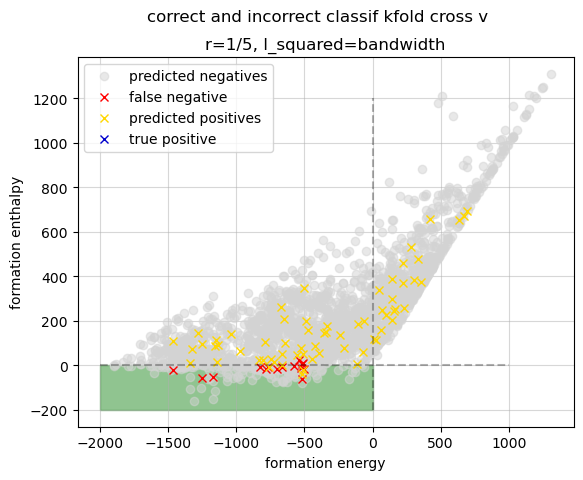

In [17]:
fig, ax = plt.subplots()
ax.grid(alpha=0.5)
ax.plot(predicted_negatives['dEf'],predicted_negatives['dH'],'o',color='lightgrey',
        alpha=0.5,label='predicted negatives')
ax.plot(false_negative['dEf'],false_negative['dH'],'x',color='red',
        label='false negative')
ax.plot(predicted_positives['dEf'],predicted_positives['dH'],'x',color='gold',
        label='predicted positives')
ax.plot(true_positives_plot['dEf'],true_positives_plot['dH'],'x',color='mediumblue',
        label='true positive')
ax.plot(np.linspace(-2000,1000,2,endpoint=True),np.zeros(2),'k--',alpha=0.3)
ax.plot(np.zeros(2),np.linspace(-200,1200,2,endpoint=True),'k--',alpha=0.3)
ax.fill_between(np.linspace(-2000,0,2,endpoint=True),y1=-200,y2=0,color='forestgreen',
                alpha=0.5)
plt.legend()
ax.set_xlabel('formation energy')
ax.set_ylabel('formation enthalpy')
ax.set_title('r=1/5, l_squared=bandwidth')
plt.suptitle('correct and incorrect classif kfold cross v')
#plt.savefig('pred_elem_only_kflod_10_50_modif_init.png')

In [18]:
print(list(predicted_positives.index))

['Y2GaC', 'Y2GeC', 'Zr2GaC', 'Zr2GeC', 'Nb2GaC', 'Nb2GeC', 'Mo2GaC', 'Mo2GeC', 'Ru2GaC', 'Ru2GeC', 'Hf2ZnC', 'Ta2ZnC', 'W2ZnC', 'Re2ZnC', 'Os2ZnC', 'Sc3PdC2', 'Ti3PdC2', 'V3PdC2', 'Cr3PdC2', 'Mn3PdC2', 'Fe3PdC2', 'Y3PdC2', 'Zr3PdC2', 'Nb3PdC2', 'Mo3PdC2', 'Mo3AgC2', 'Hf3PdC2', 'Hf3AgC2', 'Ta3PdC2', 'Ta3AgC2', 'W3PdC2', 'W3AgC2', 'Y2GaN', 'Y2GeN', 'Zr2GaN', 'Zr2GeN', 'Nb2GaN', 'Nb2GeN', 'Mo2GaN', 'Mo2GeN', 'Ru2GaN', 'Ru2GeN', 'Hf2ZnN', 'Ta2ZnN', 'W2ZnN', 'Re2ZnN', 'Os2ZnN', 'Sc3PdN2', 'Ti3PdN2', 'V3PdN2', 'Cr3PdN2', 'Mn3PdN2', 'Fe3PdN2', 'Y3PdN2', 'Zr3PdN2', 'Nb3PdN2', 'Mo3PdN2', 'Mo3AgN2', 'Hf3PdN2', 'Hf3AgN2', 'Ta3PdN2', 'Ta3AgN2', 'W3PdN2', 'W3AgN2']


In [19]:
to_plot

,M_M_density,M_M_average_ionic_radius,M_M_electron_affinity,M_M_electronegativity,M_M_first_ionization_energy,A_A_atomic_number,A_A_atomic_mass,A_A_average_cationic_radius,A_A_second_ionization_energy,X_X_average_cationic_radius,...,volume.pa,density,dEf,E_pa,dH,M,A,X,PU_label,year
compound_name,,,,,,,,,,,,,,,,,,,,,
Y2GaC,2.222646,0.260000,0.076780,0.305000,1.554315,7.750000,17.430750,0.190000,5.128785,0.0750,...,21.765913,4.950237,-352.972294,-6.649725,147.255164,Y,Ga,C,0.0,NaN
Y2GeC,2.222646,0.260000,0.076780,0.305000,1.554315,8.000000,18.160000,0.192500,3.983652,0.0750,...,21.104445,5.162573,-474.651717,-7.168759,160.149240,Y,Ge,C,0.0,NaN
Zr2GaC,2.280600,0.215000,0.108322,0.332500,1.658532,7.750000,17.430750,0.190000,5.128785,0.0750,...,17.267074,6.351460,-725.581590,-8.063147,15.508951,Zr,Ga,C,0.0,NaN
Zr2GeC,2.280600,0.215000,0.108322,0.332500,1.658532,8.000000,18.160000,0.192500,3.983652,0.0750,...,16.750491,6.619384,-804.633335,-8.539554,22.744576,Zr,Ge,C,1.0,2023.0
Nb2GaC,2.322659,0.205000,0.229352,0.400000,1.689712,7.750000,17.430750,0.190000,5.128785,0.0750,...,14.729718,7.540399,-516.255711,-8.630623,-37.047312,Nb,Ga,C,1.0,1964.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hf3AgN2,2.974833,0.141667,0.029678,0.216667,1.137512,7.833333,17.978033,0.181111,3.580733,0.0475,...,14.735368,12.609192,-1134.293605,-9.363805,90.834359,Hf,Ag,N,0.0,NaN
Ta3PdN2,3.015798,0.136667,0.053853,0.250000,1.258262,7.666667,17.736667,0.141042,3.238333,0.0475,...,13.057727,14.354795,-673.881864,-10.244350,260.668975,Ta,Pd,N,0.0,NaN
Ta3AgN2,3.015798,0.136667,0.053853,0.250000,1.258262,7.833333,17.978033,0.181111,3.580733,0.0475,...,13.524779,13.888714,-501.301294,-9.681109,347.590286,Ta,Ag,N,0.0,NaN


In [20]:
df_copy_test.sort_values(by='to_det_b', ascending=False)

,M_M_density,M_M_average_ionic_radius,M_M_electron_affinity,M_M_electronegativity,M_M_first_ionization_energy,A_A_atomic_number,A_A_atomic_mass,A_A_average_cationic_radius,A_A_second_ionization_energy,X_X_average_cationic_radius,X_X_electronegativity,m_g_5,class,label,cluster,relab,to_det_b,check_array,final_relab
compound_name,,,,,,,,,,,,,,,,,,,
W3PdN2,3.064000,0.127778,0.136045,0.393333,1.310672,7.666667,17.736667,0.141042,3.238333,0.04750,0.506667,0.000000,0.0,-1.0,7,1.0,1.845722,1.0,1.0
W3PdC2,3.064000,0.127778,0.136045,0.393333,1.310672,7.666667,17.736667,0.141042,3.238333,0.05000,0.425000,0.000000,0.0,-1.0,7,1.0,1.834262,1.0,1.0
Ta3PdN2,3.015798,0.136667,0.053853,0.250000,1.258262,7.666667,17.736667,0.141042,3.238333,0.04750,0.506667,0.166667,0.0,-1.0,7,1.0,1.823832,1.0,1.0
Ta3PdC2,3.015798,0.136667,0.053853,0.250000,1.258262,7.666667,17.736667,0.141042,3.238333,0.05000,0.425000,0.166667,0.0,-1.0,7,1.0,1.812471,1.0,1.0
Hf3PdN2,2.974833,0.141667,0.029678,0.216667,1.137512,7.666667,17.736667,0.141042,3.238333,0.04750,0.506667,0.000000,0.0,-1.0,7,1.0,1.803063,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V2AsC,1.273537,0.194375,0.131915,0.407500,1.686547,8.250000,18.730400,0.165000,4.647300,0.07500,0.637500,0.250000,0.0,-1.0,7,-1.0,-0.305037,-1.0,-1.0
Ti2AsN,1.196675,0.212917,0.018886,0.385000,1.707030,8.250000,18.730400,0.165000,4.647300,0.07125,0.760000,0.000000,0.0,-1.0,7,-1.0,-0.353555,-1.0,-1.0
Ti2AsC,1.196675,0.212917,0.018886,0.385000,1.707030,8.250000,18.730400,0.165000,4.647300,0.07500,0.637500,0.000000,0.0,-1.0,7,-1.0,-0.363447,-1.0,-1.0


In [21]:
b

np.float64(1.0231986485997453)